Chapter 17 - Causal survival analysis
===

- 17.1 Hazards and risks
- 17.2 From hazards to risks
- 17.3 Why censoring matters
- 17.4 IP weighting of marginal structural models
- 17.5 The parametric g-formula
- 17.6 G-estimation of structural nested models

# Key words

- survival analysis
- administrative end of follow-up
- administrative censoring
- competing event
- survival probability = $\Pr[T > k]$
- survival curve (monotonic)
- risk = cuumulative incidence = $1 - \Pr[T > k] = \Pr[T \leq k]$
- hazard = $\Pr[T = k \mid T > k - 1]$ = $\Pr[D_k = 1 \mid D_{k-1} = 0]$
- hazard ratio
- wide format / long format

# Formulas

The survival probability at time k:

$\Pr[D_k = 0] = \prod_{m=1}^{k} \Pr[D_m = 0 \mid D_{m-1} = 0]$

# Book Programs

## 17.1 Nonparametric estimation of survival curves

We estimate **Kaplan–Meier survival curves** for the NHEFS cohort to quantify how smoking cessation affects all-cause mortality over the 10-year follow-up.

### Kaplan–Meier estimator

$$
\hat S(t) \;=\; \prod_{t_i \le t} \Bigl(1 - \tfrac{d_i}{n_i}\Bigr)
$$

where  

- $d_i$ = number of events (deaths) at time $t_i$  
- $n_i$ = number **at risk** just *before* $t_i$

### Curve comparison

A two-sample **log-rank test** assesses whether the survival experiences of quitters ($A=1$) and continuing smokers ($A=0$) differ across the entire follow-up period.

### Code

Five solutions below are:
- [built-in modules / batteries included 🔋](#solution-with-just-built-in-modules-)
- [`scipy.stats`](#scipy)
- lifelines KaplanMeierFitter
- statsmodels SurvfuncRight
- scikit-survival kaplan_meier_estimator

#### built-in modules 😎

Batteries included solution 🔋 Except for pandas and numpy of course.

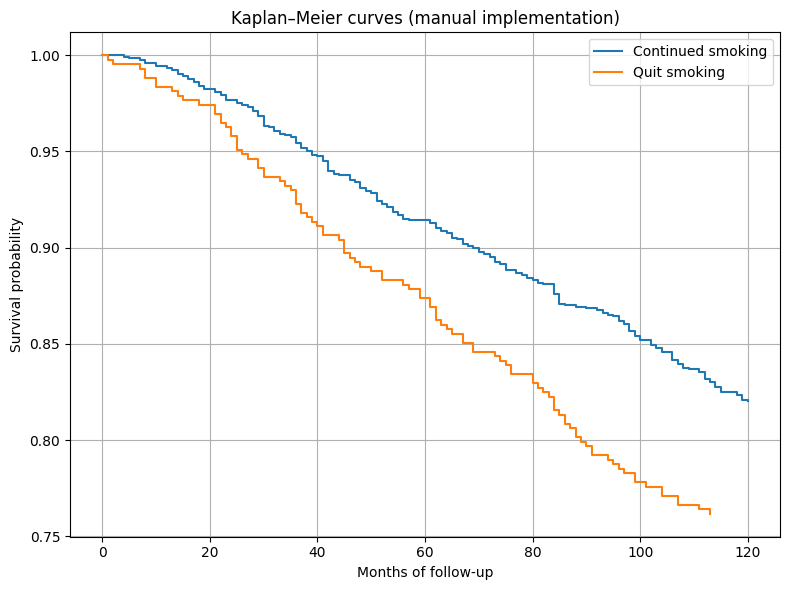

log‑rank Z = 2.781, p‑value = 0.00542


In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# 1. Load data
url = "https://miguelhernan.org/s/nhefs.csv"
df = pd.read_csv(url)

# 2. Compute survival time (months) and sort
df["survtime"] = np.where(df["death"] == 0, 120, (df["yrdth"] - 83) * 12 + df["modth"])
df = df.sort_values("survtime")


# 3. Kaplan–Meier function
def kaplan_meier(df_group):
    times = df_group["survtime"].values
    events = df_group["death"].values
    unique_events = np.sort(np.unique(times[events == 1]))
    surv = 1.0
    results = [(0, surv)]
    for t in unique_events:
        d = np.sum((times == t) & (events == 1))
        r = np.sum(times >= t)
        surv *= 1 - d / r
        results.append((t, surv))
    return pd.DataFrame(results, columns=["time", "survival"])


# 4. Calculate KM for each group
km0 = kaplan_meier(df[df.qsmk == 0])
km1 = kaplan_meier(df[df.qsmk == 1])

# 5. Plot survival curves
fig, ax = plt.subplots(figsize=(8, 6))
ax.step(km0.time, km0.survival, where="post", label="Continued smoking")
ax.step(km1.time, km1.survival, where="post", label="Quit smoking")
# ax.set_ylim(0.5, 1.02)
ax.set_xlabel("Months of follow-up")
ax.set_ylabel("Survival probability")
ax.set_title("Kaplan–Meier curves (manual implementation)")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

# 6. Manual log‑rank test (no SciPy)
groups = [0, 1]
mask = {g: df.qsmk == g for g in groups}
event_times = df.loc[df.death == 1, "survtime"].unique()

O_minus_E_sum = 0.0
V_sum = 0.0

for t in event_times:
    at_risk = df.survtime >= t
    N_j = at_risk.sum()
    O_j = df.loc[(df.survtime == t) & (df.death == 1)].shape[0]
    for g in groups:
        N_ij = df.loc[mask[g] & at_risk].shape[0]
        O_ij = df.loc[mask[g] & (df.survtime == t) & (df.death == 1)].shape[0]
        E_ij = O_j * (N_ij / N_j)
        V_ij = E_ij * ((N_j - O_j) / N_j) * ((N_j - N_ij) / (N_j - 1))
        if g == 1:
            O_minus_E_sum += O_ij - E_ij
            V_sum += V_ij

Z = O_minus_E_sum / np.sqrt(V_sum)
p_value = 2 * (1 - 0.5 * (1 + math.erf(abs(Z) / math.sqrt(2))))

print(f"log‑rank Z = {Z:.3f}, p‑value = {p_value:.5f}")

<a name="scipy"></a>
#### scipy.stats 💪

Batteries almost included, because scipy is such a common module 🔋

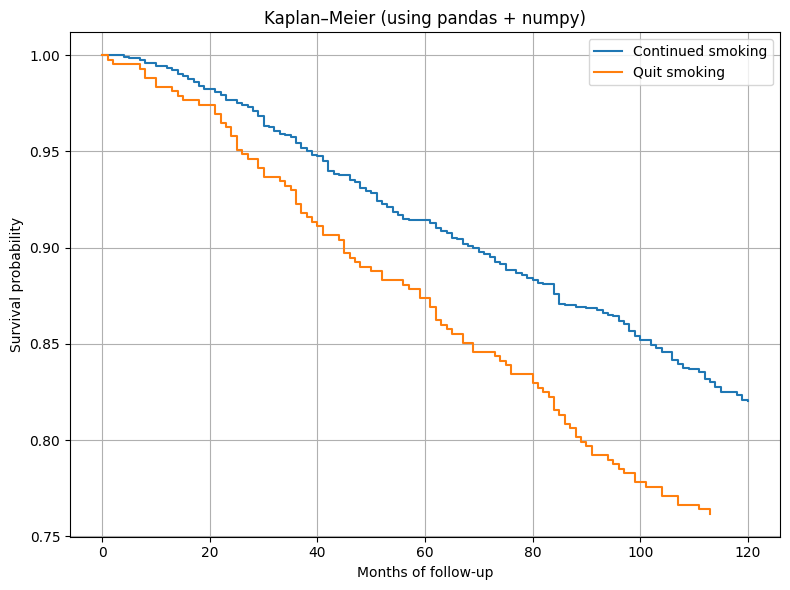

log-rank statistic = -2.781
log-rank p-value   = 0.00542


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import CensoredData, logrank

# 1. Load data
url = "https://miguelhernan.org/s/nhefs.csv"
df = pd.read_csv(url)

# 2. Compute survival time (months)
df["survtime"] = np.where(df["death"] == 0, 120, (df["yrdth"] - 83) * 12 + df["modth"])


# 3. Kaplan–Meier estimator (pandas + numpy)
def kaplan_meier(df_group):
    df_sorted = df_group.sort_values("survtime")
    times = df_sorted["survtime"].values
    events = df_sorted["death"].values
    unique_events = np.sort(np.unique(times[events == 1]))
    surv, n = 1.0, len(times)
    results = [(0, surv)]
    for t in unique_events:
        d = np.sum((times == t) & (events == 1))
        r = np.sum(times >= t)
        surv *= 1 - d / r
        results.append((t, surv))
    return pd.DataFrame(results, columns=["time", "survival"])


km0 = kaplan_meier(df[df.qsmk == 0])
km1 = kaplan_meier(df[df.qsmk == 1])

# 4. Plot KM curves
fig, ax = plt.subplots(figsize=(8, 6))
ax.step(km0.time, km0.survival, where="post", label="Continued smoking")
ax.step(km1.time, km1.survival, where="post", label="Quit smoking")
# ax.set_ylim(0.5, 1.02)
ax.set_xlabel("Months of follow-up")
ax.set_ylabel("Survival probability")
ax.set_title("Kaplan–Meier (using pandas + numpy)")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

# 5. Log-rank test: build CensoredData objects
cd0 = CensoredData(
    uncensored=df.loc[(df.qsmk == 0) & (df.death == 1), "survtime"],
    right=df.loc[(df.qsmk == 0) & (df.death == 0), "survtime"],
)
cd1 = CensoredData(
    uncensored=df.loc[(df.qsmk == 1) & (df.death == 1), "survtime"],
    right=df.loc[(df.qsmk == 1) & (df.death == 0), "survtime"],
)

res = logrank(cd0, cd1)

print(f"log-rank statistic = {res.statistic:.3f}")
print(f"log-rank p-value   = {res.pvalue:.5f}")

#### <a href="https://lifelines.readthedocs.io/en/latest/fitters/univariate/KaplanMeierFitter.html">lifelines KaplanMeierFitter</a> ⭐

This is my favorite solution, because `lifelines` automatically includes confidence intervals in its plots.

log-rank p-value = 0.00542


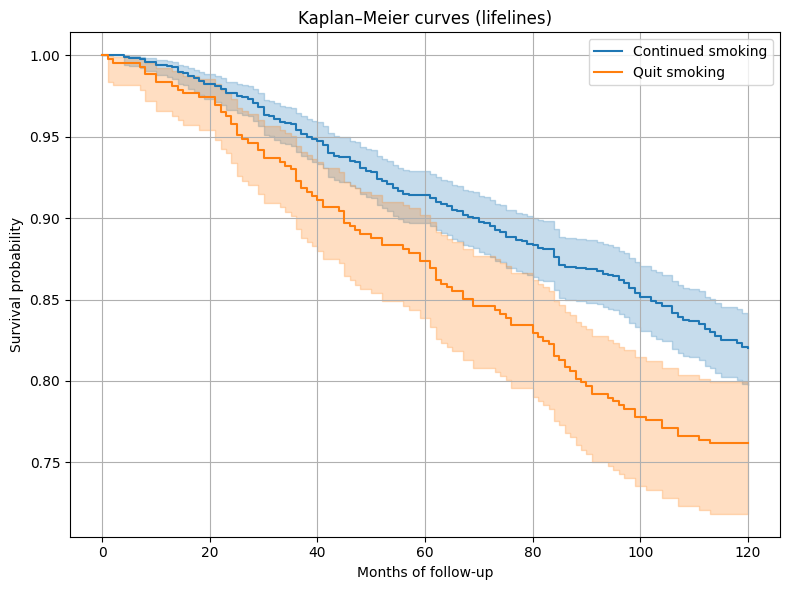

: 

In [ ]:
# Cell 3 – lifelines solution (fixed)
# !pip install lifelines  # uncomment if lifelines isn't installed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# 1. Load data
url = "https://miguelhernan.org/s/nhefs.csv"
df = pd.read_csv(url)

# 2. Survival time (vectorised with np.where)
df["survtime"] = np.where(df["death"] == 0, 120, (df["yrdth"] - 83) * 12 + df["modth"])

# 3. Kaplan–Meier fit & plot
kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

for group, label in [(0, "Continued smoking"), (1, "Quit smoking")]:
    mask = df["qsmk"] == group
    kmf.fit(
        df.loc[mask, "survtime"], df.loc[mask, "death"], label=label
    )  # one-liner per group
    kmf.plot_survival_function(ci_show=True)

# 4. Log-rank test
p_val = logrank_test(
    df.loc[df.qsmk == 0, "survtime"],
    df.loc[df.qsmk == 1, "survtime"],
    event_observed_A=df.loc[df.qsmk == 0, "death"],
    event_observed_B=df.loc[df.qsmk == 1, "death"],
).p_value
print(f"log-rank p-value = {p_val:.5f}")

# 5. Final plot tweaks
plt.title("Kaplan–Meier curves (lifelines)")
plt.xlabel("Months of follow-up")
plt.ylabel("Survival probability")
# plt.ylim((0.7, 1.02))
plt.grid(True)
plt.tight_layout()
plt.show()

#### <a href="https://www.statsmodels.org/dev/generated/statsmodels.duration.survfunc.SurvfuncRight.html">statsmodels SurvfuncRight</a> 👍

Similar to the Fiedler solution: https://github.com/jrfiedler/causal_inference_python_code/blob/master/chapter17.ipynb

In 2025 `statsmodels` is the most widely used stats module for Python: https://pypistats.org/packages/statsmodels

log-rank p-value = 0.00542


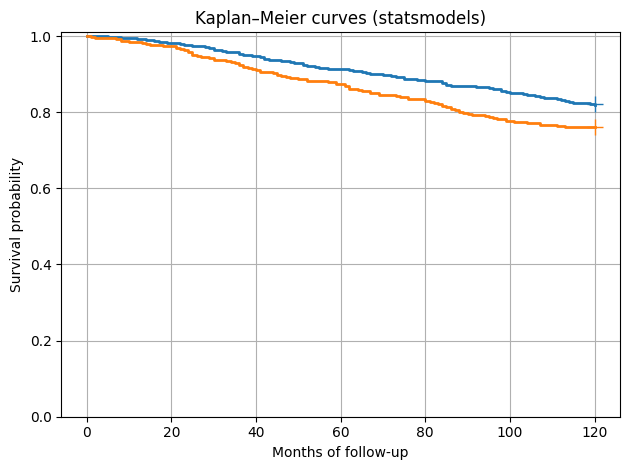

In [ ]:
# ✅ Corrected Cell 1 – statsmodels solution
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.duration.survfunc import plot_survfunc
import matplotlib.pyplot as plt

# 1. Load NHEFS
url = "https://miguelhernan.org/s/nhefs.csv"
df = pd.read_csv(url)

# 2. Define survival time with np.where
df["survtime"] = np.where(df["death"] == 0, 120, (df["yrdth"] - 83) * 12 + df["modth"])

# 3. One-liner Kaplan–Meier fits
sf_quit = sm.SurvfuncRight(
    df.loc[df.qsmk == 1, "survtime"],
    df.loc[df.qsmk == 1, "death"],
    title="Quit smoking",
)
sf_smoker = sm.SurvfuncRight(
    df.loc[df.qsmk == 0, "survtime"],
    df.loc[df.qsmk == 0, "death"],
    title="Continued smoking",
)

# 4. Log-rank test
chisq, pval = sm.duration.survdiff(df["survtime"], df["death"], df["qsmk"])
print(f"log-rank p-value = {pval:.5f}")

# 5. Plot both groups
fig = plot_survfunc([sf_smoker, sf_quit])
ax = fig.get_axes()[0]
ax.set_title("Kaplan–Meier curves (statsmodels)")
ax.set_xlabel("Months of follow-up")
ax.set_ylabel("Survival probability")
ax.grid(True)
plt.tight_layout()
plt.show()

#### <a href="https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.nonparametric.kaplan_meier_estimator.html">scikit-survival kaplan_meier_estimator</a> 👌

In 2025 `scikit-survival` is less used than lifelines, but it's an honorable mention: https://pypistats.org/packages/scikit-survival

log-rank p-value = 0.00542


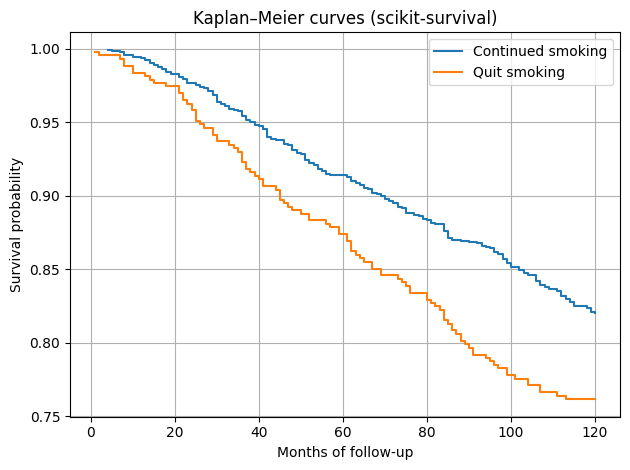

In [ ]:
# !pip install scikit-survival

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival  # <- new import
from sksurv.util import Surv  # to build structured array

# 1. Load NHEFS data
url = "https://miguelhernan.org/s/nhefs.csv"
df = pd.read_csv(url)

# 2. Survival time (same rule as Hernán & Robins)
df["survtime"] = np.where(df["death"] == 0, 120, (df["yrdth"] - 83) * 12 + df["modth"])

# 3. Kaplan–Meier estimates (one-liner per group)
t0, s0 = kaplan_meier_estimator(
    df.loc[df.qsmk == 0, "death"].astype(bool), df.loc[df.qsmk == 0, "survtime"]
)
t1, s1 = kaplan_meier_estimator(
    df.loc[df.qsmk == 1, "death"].astype(bool), df.loc[df.qsmk == 1, "survtime"]
)

# 4. Log-rank test with compare_survival
y_struct = Surv.from_arrays(event=df["death"].astype(bool), time=df["survtime"])
chisq, p_value = compare_survival(y_struct, df["qsmk"])
print(f"log-rank p-value = {p_value:.5f}")

# 5. Plot
plt.step(t0, s0, where="post", label="Continued smoking")
plt.step(t1, s1, where="post", label="Quit smoking")
# plt.ylim(0.5, 1)
plt.xlabel("Months of follow-up")
plt.ylabel("Survival probability")
plt.title("Kaplan–Meier curves (scikit-survival)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 17.2 Parametric estimation of survival curves via hazards model

Fit a logistic discrete‑time hazards model on the expanded person‑month dataset.

Model form:
$$
\text{logit}\,P(\text{no event at month }t)
= \beta_0 + \beta_1 qsmk + \beta_2 t + \beta_3 t^2
+ \beta_4 (qsmk \times t) + \beta_5 (qsmk \times t^2)
$$

Predict monthly survival for each treatment arm, cumulate, and plot the parametric survival curves over 120 months.

                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.9956      0.231     30.291      0.000       6.543       7.448
qsmk           -0.3355      0.397     -0.845      0.398      -1.114       0.443
qsmk:time      -0.0121      0.015     -0.804      0.422      -0.042       0.017
qsmk:timesq     0.0002      0.000      1.293      0.196   -8.31e-05       0.000
time           -0.0196      0.008     -2.329      0.020      -0.036      -0.003
timesq          0.0001   6.69e-05      1.878      0.060   -5.47e-06       0.000


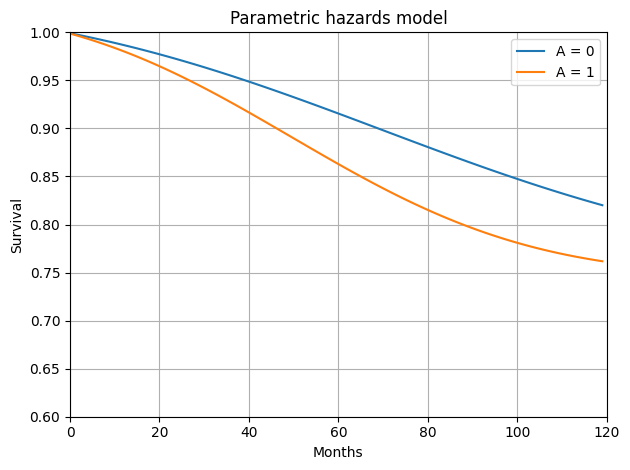

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import glm
import matplotlib.pyplot as plt

# 1. Read & compute follow-up months
url = "https://miguelhernan.org/s/nhefs.csv"
nhefs = pd.read_csv(url)

nhefs["survtime"] = np.where(
    nhefs.death == 0, 120, (nhefs.yrdth - 83) * 12 + nhefs.modth
)

# 2. Expand to person-months (vectorised repeat)
pm = nhefs.loc[nhefs.index.repeat(nhefs.survtime)].reset_index(drop=True)
pm["time"] = pm.groupby("seqn").cumcount()
pm["event"] = ((pm.time == pm.survtime - 1) & (pm.death == 1)).astype(int)
pm["timesq"] = pm.time**2
pm["no_event"] = 1 - pm.event  # response mirrors R: model P(no event)

# 3. Discrete-time hazards GLM
fit = glm(
    "no_event ~ qsmk + qsmk:time + qsmk:timesq + time + timesq",
    data=pm,
    family=sm.families.Binomial(),
).fit()
print(fit.summary().tables[1])  # ≈ R’s summary()

# 4. Predict survival under each treatment
grid = pd.DataFrame({"time": range(120)})
grid["timesq"] = grid.time**2
for a in (0, 1):
    g = grid.assign(qsmk=a)
    grid[f"p{a}"] = fit.predict(g)
    grid[f"surv{a}"] = grid[f"p{a}"].cumprod()

# 5. Plot
plt.plot(grid.time, grid.surv0, label="A = 0")
plt.plot(grid.time, grid.surv1, label="A = 1")
plt.xlim(0, 120)
plt.ylim(0.6, 1)
plt.xlabel("Months")
plt.ylabel("Survival")
plt.title("Parametric hazards model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 17.3 Estimation of survival curves via IP weighted hazards model

Apply inverse‑probability weighting (IPW) to adjust for baseline confounding.

1. Estimate stabilized weights:  
   numerator = Pr(qsmk), denominator = Pr(qsmk | baseline covariates).

2. Fit the same logistic hazards model but with `weights = sw.a`.

3. Create IPW survival curves representing marginal survival under each treatment strategy.

                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.8970      0.221     31.241      0.000       6.464       7.330
qsmk                  0.1794      0.440      0.408      0.683      -0.683       1.042
time                 -0.0189      0.008     -2.345      0.019      -0.035      -0.003
I(time ** 2)          0.0001    6.4e-05      1.846      0.065   -7.31e-06       0.000
qsmk:time            -0.0189      0.016     -1.155      0.248      -0.051       0.013
qsmk:I(time ** 2)     0.0002      0.000      1.556      0.120   -5.47e-05       0.000


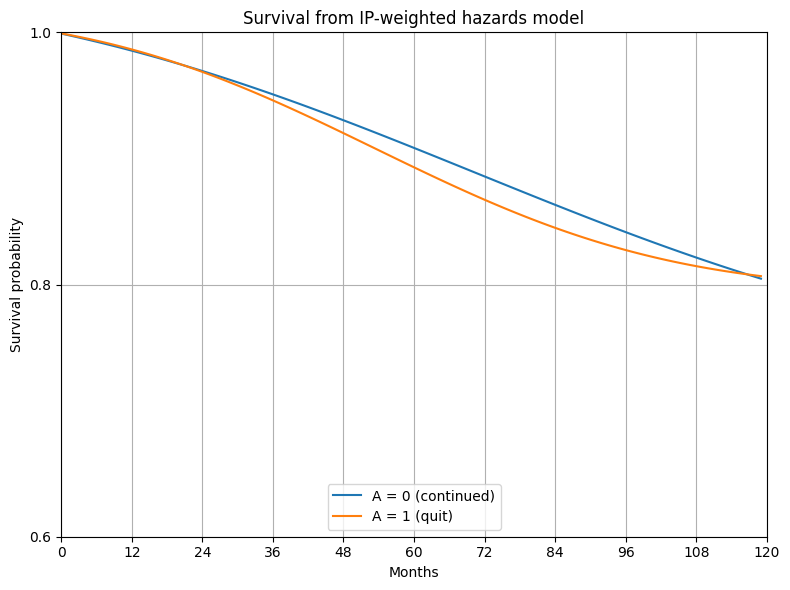

In [ ]:
# IP-weighted hazards model in one cell
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# 1. Load NHEFS and follow-up time (Program 17.1 rule)
url = "https://miguelhernan.org/s/nhefs.csv"
df = pd.read_csv(url)
df["survtime"] = np.where(df["death"] == 0, 120, (df["yrdth"] - 83) * 12 + df["modth"])

# ------------------------------------------------------------------------------
# 2. Stabilised inverse-probability (IP) weights
denom = smf.glm(
    formula=(
        "qsmk ~ sex + race + age + I(age**2) + C(education) + "
        "smokeintensity + I(smokeintensity**2) + "
        "smokeyrs + I(smokeyrs**2) + C(exercise) + C(active) + "
        "wt71 + I(wt71**2)"
    ),
    data=df,
    family=sm.families.Binomial(),
).fit()

num = smf.glm(formula="qsmk ~ 1", data=df, family=sm.families.Binomial()).fit()

df["pd"] = denom.predict(df)
df["pn"] = num.predict(df)
df["sw"] = np.where(
    df["qsmk"] == 1, df["pn"] / df["pd"], (1 - df["pn"]) / (1 - df["pd"])
)

# ------------------------------------------------------------------------------
# 3. Person-month expansion (vectorised repeat)
long = df.loc[df.index.repeat(df["survtime"])].reset_index(drop=True)
long["time"] = long.groupby("seqn").cumcount()
long["event"] = ((long["time"] == long["survtime"] - 1) & (long["death"] == 1)).astype(
    int
)
long["timesq"] = long["time"] ** 2
long["no_event"] = 1 - long["event"]
long["w"] = long["sw"]

# ------------------------------------------------------------------------------
# 4. Weighted discrete-time hazards GLM (logistic)
fit = smf.glm(
    #    formula="no_event ~ qsmk + qsmk:time + qsmk:np.power(time, 2) + time + np.power(time, 2)",
    formula="no_event ~ qsmk * (time + I(time**2))",
    #    formula = "no_event ~ qsmk * poly(time, 2)",
    data=long,
    family=sm.families.Binomial(),
    # var_weights=long["w"],
    freq_weights=long["w"],
).fit()

print(fit.summary().tables[1])

# ------------------------------------------------------------------------------
# 5. Predict monthly hazards and build survival curves
grid = pd.DataFrame({"time": np.arange(120)})
grid["timesq"] = grid["time"] ** 2

surv = {}
for a in (0, 1):
    g = grid.assign(qsmk=a)
    surv[a] = fit.predict(g).cumprod()  # product of (1 - hazard) gives survival

# ------------------------------------------------------------------------------
# 6. Plot
plt.figure(figsize=(8, 6))
plt.plot(grid["time"], surv[0], label="A = 0 (continued)")
plt.plot(grid["time"], surv[1], label="A = 1 (quit)")

plt.xlim(0, 120)
plt.ylim(0.6, 1)
plt.xticks(np.arange(0, 121, 12))
plt.yticks(np.arange(0.6, 1.01, 0.2))
plt.xlabel("Months")
plt.ylabel("Survival probability")
plt.title("Survival from IP-weighted hazards model")
plt.legend(loc="lower center")
plt.grid(True)
plt.tight_layout()
plt.show()

## 17.4 Estimating of survival curves via g-formula

Use standardization to estimate marginal survival curves under each treatment.

1. Fit logistic hazard model including baseline covariates (like in IPW).

2. For each individual, simulate 120-month person‑month histories under qsmk=0 and qsmk=1.

3. Compute individual survival curves by month, then average across all individuals to get marginal survival.

                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  9.2724      1.379      6.723      0.000       6.569      11.976
C(education)[T.2]          0.1401      0.157      0.895      0.371      -0.167       0.447
C(education)[T.3]          0.4335      0.153      2.841      0.005       0.134       0.733
C(education)[T.4]          0.2350      0.279      0.842      0.400      -0.312       0.782
C(education)[T.5]          0.3750      0.239      1.571      0.116      -0.093       0.843
C(exercise)[T.1]           0.1469      0.179      0.820      0.412      -0.204       0.498
C(exercise)[T.2]          -0.1504      0.176     -0.854      0.393      -0.496       0.195
C(active)[T.1]            -0.1601      0.130     -1.232      0.218      -0.415       0.095
C(active)[T.2]            -0.2294      0.188     -1.222      0.222      -0.597       0.139

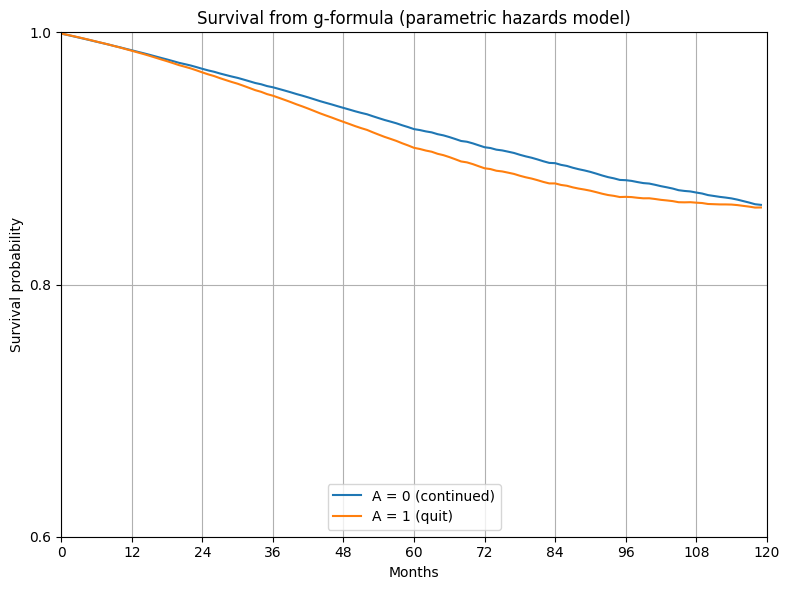

In [ ]:
# ▒▒ Program 17.4 — g-formula survival curves (single cell) ▒▒
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. Load NHEFS and months of follow-up
url = "https://miguelhernan.org/s/nhefs.csv"
df = pd.read_csv(url)
df["survtime"] = np.where(
    df.death == 0, 120, (df.yrdth - 83) * 12 + df.modth
)  # rule from Hernán & Robins

# 2. Person-month expansion (vectorised repeat → expandRows analogue)
long = df.loc[df.index.repeat(120)].reset_index(drop=True)
long["time"] = long.groupby("seqn").cumcount()
long = long[long["time"] < long["survtime"]]  # drop months after censoring
long["event"] = ((long.time == long.survtime - 1) & (long.death == 1)).astype(int)
long["timesq"] = long.time**2
long["no_event"] = 1 - long.event

# 3. Discrete-time hazards GLM with baseline covariates (as in R)
formula = (
    "no_event ~ qsmk + qsmk:time + qsmk:timesq + "
    "time + timesq + sex + race + age + I(age**2) + C(education) + "
    "smokeintensity + I(smokeintensity**2) + smkintensity82_71 + "
    "smokeyrs + I(smokeyrs**2) + C(exercise) + C(active) + "
    "wt71 + I(wt71**2)"
)
fit = smf.glm(
    formula=formula, data=long, family=sm.families.Binomial()
).fit()  # GLM binomial link
print(fit.summary().tables[1])

# 4. Predict P(no-event) for every subject-month under A=0 and A=1
tmpl = long[
    [
        "seqn",
        "time",
        "timesq",
        "sex",
        "race",
        "age",
        "education",
        "smokeintensity",
        "smkintensity82_71",
        "smokeyrs",
        "exercise",
        "active",
        "wt71",
    ]
].drop_duplicates(["seqn", "time"])
curves = {}
for a in (0, 1):
    g = tmpl.assign(qsmk=a)
    curves[a] = fit.predict(g).groupby(g["seqn"]).cumprod()  # subject-specific survival

# 5. Average subject-specific survival to obtain marginal g-formula curve
grid = pd.DataFrame({"time": range(120)})
grid["surv0"] = curves[0].groupby(tmpl["time"]).mean().values
grid["surv1"] = curves[1].groupby(tmpl["time"]).mean().values
grid["diff"] = grid["surv1"] - grid["surv0"]

# 6. Plot
plt.figure(figsize=(8, 6))
plt.plot(grid.time, grid.surv0, label="A = 0 (continued)")
plt.plot(grid.time, grid.surv1, label="A = 1 (quit)")
plt.xlim(0, 120)
plt.ylim(0.6, 1)
plt.xticks(np.arange(0, 121, 12))
plt.yticks(np.arange(0.6, 1.01, 0.2))
plt.xlabel("Months")
plt.ylabel("Survival probability")
plt.title("Survival from g-formula (parametric hazards model)")
plt.legend(loc="lower center")
plt.grid(True)
plt.tight_layout()
plt.show()

## 17.5 Estimating of median survival time ratio via a structural nested AFT model

Estimate the log median survival‑time ratio $\psi$ using G‑estimation.

1. Fit a logistic model for treatment to get Pr(qsmk | L).
2. Define the estimating function:
   $$ S(\psi)=\sum_i \Delta_i(\psi)\,(A_i - \hat p_i) $$
   where $\Delta_i(\psi)$ indicates compatibility of observed survival under $\psi$.
3. Solve $S(\psi)=0$ to get $\hat\psi$ and invert the score to find a 95% CI via $\chi^2_1$ cut‑point.

In [ ]:
ALPHA = 0.05  # two-sided 95 % CI
FOLLOW_UP = 120  # months of follow-up
STEP = 0.05  # bracket-expansion step for CI search
MAX_WIDTH = 1.0  # max search width (±1 log-ratio)

# Structural-nested AFT (Program 17·5)

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import chi2
from scipy.optimize import minimize_scalar, root_scalar


# Parameters and chi-square cutoff for two-sided 95% CI
ALPHA = 0.05
FOLLOW_UP = 120  # months
STEP = 0.05
MAX_WIDTH = 1.0
CHI2_CUT = chi2.ppf(1 - ALPHA, df=1)  # e.g. ≈3.84 for 95% CI


# 1. Load data and compute observed failure time
url = "https://miguelhernan.org/s/nhefs.csv"
df = pd.read_csv(url)
df["survtime"] = np.where(
    df["death"] == 1, (df["yrdth"] - 83) * 12 + df["modth"], np.nan
)


# 2. Fit treatment model E[A|L]
treat_formula = (
    "qsmk ~ sex + race + age + I(age**2) + C(education) + "
    "smokeintensity + I(smokeintensity**2) + smokeyrs + "
    "I(smokeyrs**2) + C(exercise) + C(active) + wt71 + I(wt71**2)"
)
treat_mod = smf.glm(treat_formula, data=df, family=sm.families.Binomial()).fit()
df["p_qsmk"] = treat_mod.predict(df)


# 3. Prepare data for estimating equation
d = df.dropna(subset=["survtime"]).copy()


def delta_vector(psi):
    """Indicator Delta_i(psi) per structural model."""
    if psi >= 0:
        return np.where(
            (d.qsmk == 0) | ((d.qsmk == 1) & (psi <= np.log(FOLLOW_UP / d.survtime))),
            1,
            0,
        )
    return np.where(
        (d.qsmk == 1) | ((d.qsmk == 0) & (psi > np.log(d.survtime / FOLLOW_UP))), 1, 0
    )


def score_quad(psi_value):
    """Quadratic estimating function S(psi) ~ chi-square with 1 df."""
    delta = delta_vector(psi_value)
    s_vec = delta * (d.qsmk - d.p_qsmk)
    s_mean = s_vec.mean()
    s_centered = s_vec - s_mean
    sigma = float(np.dot(s_centered, s_centered)) or 1e-16
    return (s_vec.sum() ** 2) / sigma


# 4. Estimate psi_hat by minimizing the score
opt_res = minimize_scalar(score_quad, bounds=(-0.2, 0.2), method="bounded")
psi_hat = opt_res.x


# 5. Compute 95% CI via adaptive bracket and root-finding
def find_ci_bound(start, step, direction):
    """Expand bracket until f(x)-CHI2_CUT changes sign."""
    f0 = score_quad(start) - CHI2_CUT
    edge = start
    width = 0
    while np.sign(score_quad(edge) - CHI2_CUT) == np.sign(f0) and width < MAX_WIDTH:
        edge += direction * step
        width += step
    if np.sign(score_quad(edge) - CHI2_CUT) == np.sign(f0):
        return None
    bracket = (edge, start) if direction < 0 else (start, edge)
    return root_scalar(
        lambda x: score_quad(x) - CHI2_CUT, bracket=bracket, method="bisect"
    ).root


psi_low = find_ci_bound(psi_hat, STEP, direction=-1)
psi_high = find_ci_bound(psi_hat, STEP, direction=1)


# 6. Output results
print(f"psi_hat = {psi_hat:.4f}")
if psi_low is not None and psi_high is not None:
    print(f"95% CI   = ({psi_low:.4f}, {psi_high:.4f})")
else:
    print("95% CI   = One-sided (bound not reached)")
print(f"Median survival-time ratio = {np.exp(psi_hat):.3f}")

psi_hat = -0.0505
95% CI   = (-0.2231, 0.3331)
Median survival-time ratio = 0.951


---

# Causality Study Circle